# Tutorial 4: ML on the best [2~200] features

---

### Introduction

Hello, this notebook will show how to use machine learning (ML) to classify apples using the best [2, .. , 50] wavelength. The notebook will show how to visualize the final accuracy and their relative performance in two different graphs.

first, let us call the data

In [1]:
%store -r df_input_RG
%store -r y_RG
%store -r df_RG

In [2]:
y_RG = y_RG.map({'S': 1, 'B': 0})

---

calling some packages

In [3]:
# Python packages 
import pandas as pd # for importing data into data frame format
import seaborn as sns # For drawing useful graphs, such as bar graphs
import numpy as np
import matplotlib.pyplot as plt

---

<b><i> Data splitting </i></b> 

In [4]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest  = train_test_split( df_input_RG, y_RG, test_size = 0.3, random_state=3, stratify=y_RG) # train and valid sets



In [5]:
print(Xtrain.shape)
print(Xtest.shape)

(393, 2074)
(169, 2074)


---

<b><i> get the best N features </i></b> 

In [6]:
%store -r featImp_RG

In [7]:
arrimp = np.array(featImp_RG).mean(0)
sorted_idx = arrimp.argsort()
print(sorted_idx[-10:])

[1316 1284 1093 1290   60 1034 1068 1029 1070 1107]


In [8]:
cols_ordered = df_input_RG.columns[sorted_idx][-200:]
cols_ordered

Index([1155.366, 1281.582,  992.588, 1180.082, 1968.596,  1124.79,  890.942,
        926.274, 2250.556, 1510.863,
       ...
       1445.173, 1419.847, 1285.394, 1424.528,  850.046, 1248.864, 1269.657,
       1245.863, 1270.902, 1294.379],
      dtype='object', length=200)

---

<b><i> prepare diffrint feature set sizes </i></b> 

In [9]:
number_features = [2, 4, 6, 8, 10, 20, 50, 100, 200] # define the number features. 


---

<b><i> ML model and thier hyper-parameters </i></b> 

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from numpy import random as np_random

first let us define the model


In [11]:
lr = LogisticRegression()
svm = SVC(kernel="rbf")
rf = RandomForestClassifier(random_state=1)
xgb = XGBClassifier(random_state=1)
knns = KNeighborsClassifier()
anns = MLPClassifier(max_iter=3000, random_state=1, activation = 'relu', solver = 'sgd')

defining the hyper-paramter per model

In [17]:
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
lr_par = dict(solver=solvers,penalty=penalty,C=c_values)

##############################
C_range = np.logspace(-1, 10, 20) # define a set of values for the parameter C
gamma_range = np.logspace(-9, 3, 20) # define a set of values for the parameter gamma

svm_par = dict(gamma=gamma_range, C=C_range)

#########################

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

#max_features = ['sqrt', 'log2']

rf_par = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#######################
# https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook
xgb_par = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5, 9],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 8]
        }
##################################
n_neighbors = range(1, 30, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

knns_par = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
################
anns_par = {
    'hidden_layer_sizes': [(3,3),(5,5),(8,3)],
#     'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001,0.01,0.1, 0.05, 0.005 , 0.005, 0.00005],
#     'learning_rate': ['constant','adaptive'],
}
################

group the above into two lists

In [18]:
models = [[lr, 'lr', 14], [svm, 'svm', 15], [rf, 'rf', 30], [xgb, 'xgb', 30], [knns, 'knns', 30], [anns, 'anns', 30]]
par = [lr_par, svm_par, rf_par, xgb_par, knns_par, anns_par]

# models = [[lr, 'lr', 14]]
# par = [lr_par]

---

<b><i> train and test </i></b> 

In [19]:
from source.ml_acc import get_accuracy_ml

In [20]:
num_ml_tools = len(par)
ml_dicts = {}

for m, par in zip(models, par):
    key0 = str(m[1])
    ml_dicts[key0] = {}
    for f in number_features:
        print(f)
        print(cols_ordered[-f:])
        print(type(Xtrain))
        xtr =  Xtrain[cols_ordered[-f:]]
        xte =  Xtest[cols_ordered[-f:]]
        # results = get_accuracy_ml (m[0], m[2], par, np.array(xtr), np.array(Ytrain), np.array(xte), np.array(Ytest)) # to get the accuracies for the ml model
        results = get_accuracy_ml (m[0], m[2], par, np.array(xtr), np.array(Ytrain), np.array(xtr), np.array(Ytrain)) # to get the accuracies for the ml model

        key = str(m[1])+","+str((f))
        ml_dicts[key0][key] = {}

        ml_dicts[key0][key]['tot_acc'] = results[0]
        ml_dicts[key0][key]['jack_train'] = results[1]
        ml_dicts[key0][key]['jack_test'] = results[2]

2
Index([1270.902, 1294.379], dtype='object')
<class 'pandas.core.frame.DataFrame'>
4
Index([1269.657, 1245.863, 1270.902, 1294.379], dtype='object')
<class 'pandas.core.frame.DataFrame'>
100
Index([1217.774, 1046.263, 1484.903, 2452.829, 1098.577, 1382.742, 1450.023,
        1520.61,  1296.32,  1172.08,  995.256,  1012.75, 1433.983, 1464.769,
       1262.855, 1020.323, 1068.689,  839.858, 2441.281, 1042.896, 1277.163,
        1497.77, 1138.621, 2485.753,  908.742, 1184.395,  934.285,  1400.67,
       1458.178,  1172.61, 1142.132, 1465.597,  887.283, 1441.958,  891.555,
       1376.867, 1047.955, 1509.104, 1422.964, 1259.786,  1456.54, 1287.949,
       1010.382, 1113.677, 1056.926, 1992.806, 1467.256, 1435.571, 1155.881,
        1282.85, 1475.606, 1275.906, 1509.983, 1496.906, 1430.028, 2473.894,
       1291.799, 2450.511, 1428.452, 1256.733, 1482.356, 1461.466, 1021.529,
       1282.216,  853.684, 1437.959, 1252.483, 1416.743, 1190.923, 1507.349,
       1005.289, 1284.758, 1450.834, 1

In [22]:
import json

In [23]:
with open('ml_rg.txt', 'w') as file:
     file.write(json.dumps(ml_dicts)) # use `json.loads` to do the reverse

---

<b><i> accuracy visualisation </i></b> 

In [24]:
import json
with open('ml_rg.txt') as f:
    data = f.read()
    
ml_dicts = json.loads(data)

with open('base_rg_tr.txt') as f:
    data = f.read()
    
baseDict = json.loads(data)
baseDict['lr'].keys()    

dict_keys(['lr, all'])

In [25]:
print(baseDict['lr'].keys()    )
print(ml_dicts['lr'].keys()    )

dict_keys(['lr, all'])
dict_keys(['lr,2', 'lr,4', 'lr,6', 'lr,8', 'lr,10', 'lr,20', 'lr,50', 'lr,100', 'lr,200'])


In [26]:
from source.calculate_jack import jack_SD # importing the baseline code from source.basline file

In [27]:
arr_all = []
for m, d in zip (models, ml_dicts.keys()):
    acc_arr = [] 
    sd_arr = [] 

    # print(ml_dicts[d])
    for key in ml_dicts[d].keys():
        acc_arr.append(ml_dicts[d][key][ 'tot_acc' ]) # append total accuracy to an array
        sd_train = jack_SD(np.zeros( len(ml_dicts[d][key][ 'jack_train' ]) ), ml_dicts[d][key][ 'jack_train' ])[0]
        sd_test = jack_SD(np.zeros( len(ml_dicts[d][key][ 'jack_test' ]) ), ml_dicts[d][key][ 'jack_test' ])[0]
        sd = np.sqrt( np.array((sd_train**2)) + np.array((sd_test**2)))
        sd_arr.append(sd) # append sd_arr to an array
    arr_all.append([ list(ml_dicts[d].keys()), acc_arr, sd_arr])    

In [28]:
print(arr_all)

[[['lr,2', 'lr,4', 'lr,6', 'lr,8', 'lr,10', 'lr,20', 'lr,50', 'lr,100', 'lr,200'], [0.6203208556149733, 0.6197916666666666, 0.7241379310344828, 0.7476190476190476, 0.7641509433962265, 0.7909090909090909, 0.7981651376146789, 0.7963800904977375, 0.8666666666666667], [0.04868048415559646, 0.04210780135748056, 0.0424025148301255, 0.039149205832045786, 0.04709401327275647, 0.0364054414108403, 0.035760168100680646, 0.17169178995958917, 0.03202096489865166]], [['svm,2', 'svm,4', 'svm,6', 'svm,8', 'svm,10', 'svm,20', 'svm,50', 'svm,100', 'svm,200'], [0.6217391304347826, 0.6200873362445415, 0.7761904761904762, 0.8108108108108109, 0.8110599078341014, 0.7946428571428571, 0.8, 0.8817733990147784, 0.9313725490196079], [0.03614388249414825, 0.2560636545022117, 0.10013112333397713, 0.0301016607638664, 0.0911481573811468, 0.04004354442853574, 0.11510436183278785, 0.31279630577249556, 0.03595964215927104]], [['rf,2', 'rf,4', 'rf,6', 'rf,8', 'rf,10', 'rf,20', 'rf,50', 'rf,100', 'rf,200'], [1.0, 0.798076

[0.    0.375 0.75  1.125 1.5   1.875 2.25  2.625 3.   ]
[5.    5.375 5.75  6.125 6.5   6.875 7.25  7.625 8.   ]
[10.    10.375 10.75  11.125 11.5   11.875 12.25  12.625 13.   ]
[15.    15.375 15.75  16.125 16.5   16.875 17.25  17.625 18.   ]
[20.    20.375 20.75  21.125 21.5   21.875 22.25  22.625 23.   ]
[25.    25.375 25.75  26.125 26.5   26.875 27.25  27.625 28.   ]


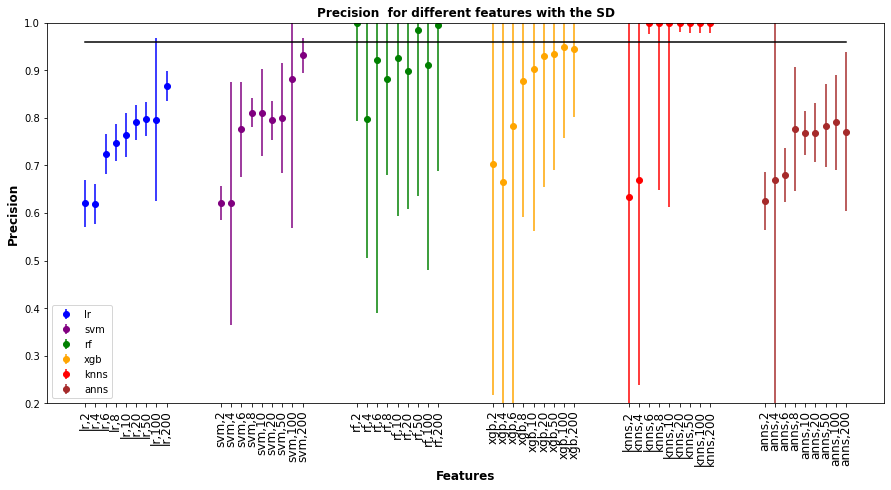

In [30]:
colors = ['blue', 'purple', 'green', 'orange', 'red', 'brown']
plt.figure(figsize=(15, 7))
plt.title( "Precision  for different features with the SD", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.ylabel("Precision", fontweight ='bold', fontsize =12)

count = 0
n = len(colors)-1

space = []
tickFeat = []

for result, model, color in zip(arr_all, models, colors):
    a = np.linspace(n*count, n*(1+count)-2,9)
    print(a)
    space.extend(a)
    tickFeat.extend(result[0])
    plt.errorbar( a, result[1], result[2], fmt='o', label =model[1], color = color)
    count += 1

plt.plot(np.array(space),[0.959595]*54, color = 'Black')            
plt.xticks(space, tickFeat, rotation = 'vertical',  fontsize =12)
plt.ylim(.2, 1)
plt.legend()

plt.show()

<b><i> relative performance </i></b> 

In [35]:
arr_diff_all = []

for m, m_key in zip (models, ml_dicts.keys()):
    acc_diff_arr = [] 
    sd_diff_arr = [] 
    for f_key in ml_dicts[m_key].keys():
        value = f_key.split(',')
        acc_diff_arr.append( ml_dicts[m_key][f_key][ 'tot_acc' ] - baseDict['lr']['lr, all'][ 'tot_acc' ]  )

        sd_train = jack_SD( baseDict['lr']['lr, all'][ 'jack_train' ], ml_dicts[m_key][f_key]['jack_train'] )[0]
        sd_test = jack_SD(  baseDict['lr']['lr, all'][ 'jack_test' ],  ml_dicts[m_key][f_key]['jack_test']   )[0]

        sd = np.sqrt( np.array((sd_train**2)) + np.array((sd_test**2)))
        sd_diff_arr.append(sd) # append sd_arr to an array
    arr_diff_all.append([ list(ml_dicts[m_key].keys()), acc_diff_arr, sd_diff_arr]) 

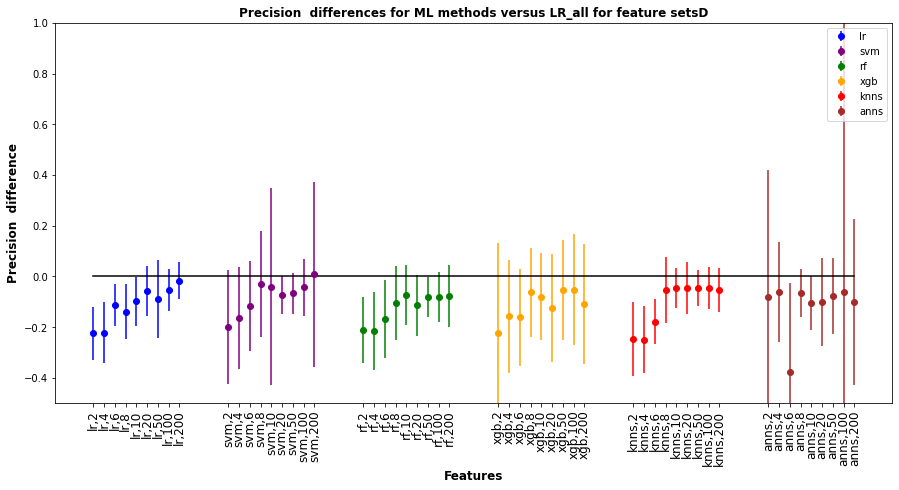

In [36]:
colors = ['blue', 'purple', 'green', 'orange', 'red', 'brown']
plt.figure(figsize=(15, 7))
plt.title( "Precision  differences for ML methods versus LR_all for feature setsD", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.ylabel("Precision  difference", fontweight ='bold', fontsize =12)

count = 0
n = len(colors)-0.5
space = []
tickFeat = []

for result, model, color in zip(arr_diff_all, models, colors):
    a = np.linspace(n*count, n*(1+count)-2,9)
    space.extend(a)
    tickFeat.extend(result[0])
    plt.errorbar( a, result[1], result[2], fmt='o', label =model[1], color = color)
    count += 1
    
plt.plot(np.array(space), np.zeros(9*6), color = 'Black')        
plt.xticks(space, tickFeat, rotation = 'vertical',  fontsize =12)
plt.ylim(-.5, 1)
plt.legend()

plt.show()